# Ex 2 - Transfer learning

Group: 12
###### Names: Luginbühl, Trottman, Shushack, Nann

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds  # first: pip install tensorflow_datasets

from sklearn.metrics import accuracy_score

In [30]:
print(tf.config.list_physical_devices()) # why can't I connect to M1... 

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Load the Dataset and visualize it

In [31]:
# Download and split the food101 dataset
(train_ds, validation_ds, test_ds), info = tfds.load(
    "food101",
    split=["train", "validation[:50%]", "validation[50%:]"],
    as_supervised=True,
    with_info=True
)

In [32]:
# Filter the dataset to keep the first 20 classes only.
N_CLASSES = 20
CLASS_NAMES = info.features['label'].names[:N_CLASSES]

train_ds = train_ds.filter(lambda img, label: label < N_CLASSES)
validation_ds = validation_ds.filter(lambda img, label: label < N_CLASSES)
test_ds = test_ds.filter(lambda img, label: label < N_CLASSES)

In [33]:
## This step takes too much time. It is not madatory to execute it.
# print("Training samples: %d" % train_ds.reduce(0, lambda x,_: x+1).numpy())   # excluded for faster reruns
# print("Validation samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())
# print("Tests samples: %d" % test_ds.reduce(0, lambda x,_: x+1).numpy())

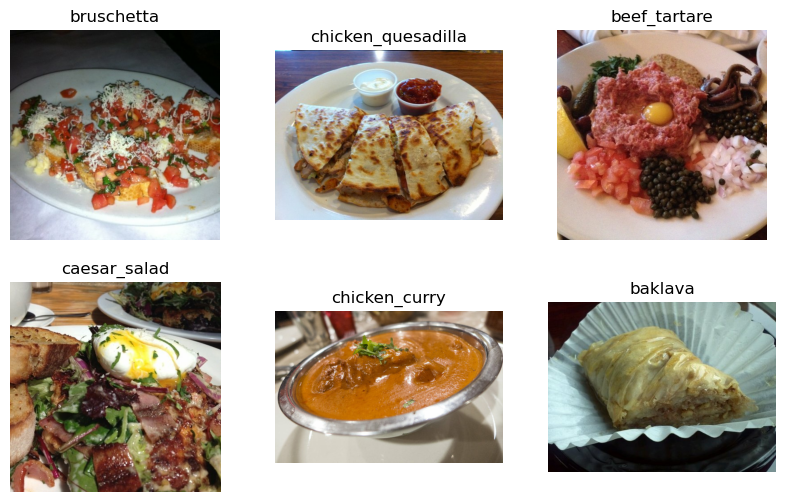

In [34]:
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label])
    plt.axis("off")

## Resize and normalize

In [35]:
# TODO Resize the images in the training, validation and test set

def resize_image(image, label):
    resized_image = tf.image.resize(image, (224, 224))  # habe irgendwo gelesen dass das noch ein gängiges format ist
    return resized_image, label

train_ds = train_ds.map(resize_image)
validation_ds = validation_ds.map(resize_image)
test_ds = test_ds.map(resize_image)

In [36]:
# Normalize the images

def normalize_image(image, label):
    normalized_image = tf.image.per_image_standardization(image)  # causing problems (i.e. might be cause for my problems? even though images look ok)
    #normalized_image = image / 255.0
    return normalized_image, label

train_ds = train_ds.map(normalize_image)
validation_ds = validation_ds.map(normalize_image)
test_ds = test_ds.map(normalize_image)

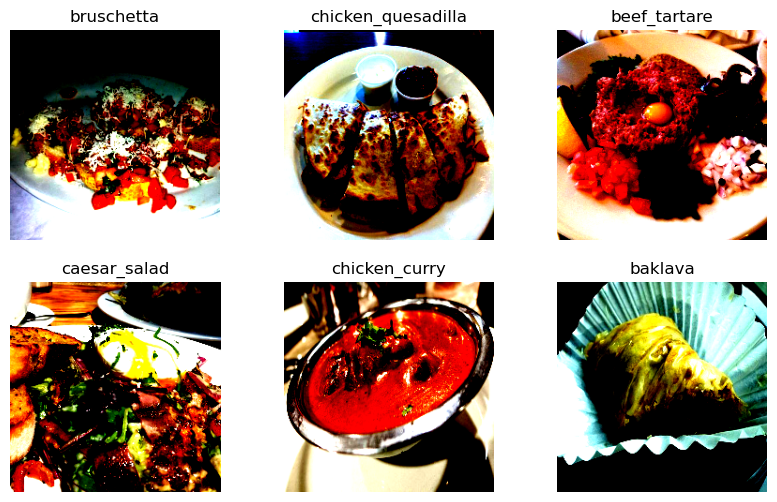

In [37]:
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label])
    plt.axis("off")

In [38]:
# One hot encode the labels

def encode_image(image, label):
    one_hot_label = tf.one_hot(label, N_CLASSES)
    return image, one_hot_label

train_ds = train_ds.map(encode_image)
validation_ds = validation_ds.map(encode_image)
test_ds = test_ds.map(encode_image)


In [39]:
# test ob das hilft beim shape mismatch
BATCH_SIZE = 64

train_ds = train_ds.cache()
validation_ds = validation_ds.cache()
test_ds = test_ds.cache()

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

## Data-Augmentation

In [40]:
# Optional define/implements data-augmentation

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image) 
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

train_ds = train_ds.map(augment_image)

## Training
### Step 1: Only train the head of the network

In [41]:
%%time
# Load the pretrained model from the available models: https://keras.io/api/applications/#available-models. 
# Load the imagenet weights but do not include the ImageNet classifier at the top.
#
# Tip, don't choose models that are too big because the training could take hours. 
# A model like mobilenet is more than enough for the exercise.

from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.applications import EfficientNetB0

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = EfficientNetB0(weights='imagenet', include_top=False)

# Freeze the base_model
base_model.trainable = False

# Create the model structure
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(N_CLASSES, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 20)                25620     
                                                                 
Total params: 2,283,604
Trainable params: 25,620
Non-trainable params: 2,257,984
_________________________________________________________________
CPU times: user 555 ms, sys: 15.7 ms, total:

In [42]:
%%time

# does not work without specifying a batch size (shape does not match otherwise)
#batch_size = 64
#train_ds = train_ds.batch(batch_size)
#validation_ds = validation_ds.batch(batch_size)

#train_ds = train_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
#validation_ds = validation_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
#test_ds = test_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Compile the model with your optimizer, your loss and your metrics
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Optional: Define and use callbacks
callbacks = []

step1_history = model.fit(train_ds, epochs=10, validation_data=validation_ds,
                          callbacks=callbacks) # You should us a relatively big learning rate: 1e-3

Epoch 1/10
235/235 [==============================] - 110s 457ms/step - loss: 1.7146 - accuracy: 0.4945 - val_loss: 1.2047 - val_accuracy: 0.6305
Epoch 2/10
235/235 [==============================] - 97s 413ms/step - loss: 1.1787 - accuracy: 0.6425 - val_loss: 1.0982 - val_accuracy: 0.6583
Epoch 3/10
235/235 [==============================] - 98s 417ms/step - loss: 1.0491 - accuracy: 0.6797 - val_loss: 1.0407 - val_accuracy: 0.6866
Epoch 4/10
235/235 [==============================] - 99s 421ms/step - loss: 0.9758 - accuracy: 0.7019 - val_loss: 1.0507 - val_accuracy: 0.6762
Epoch 5/10
235/235 [==============================] - 99s 421ms/step - loss: 0.9324 - accuracy: 0.7116 - val_loss: 1.0449 - val_accuracy: 0.6838
Epoch 6/10
235/235 [==============================] - 97s 411ms/step - loss: 0.8760 - accuracy: 0.7293 - val_loss: 1.0297 - val_accuracy: 0.6838
Epoch 7/10
235/235 [==============================] - 98s 415ms/step - loss: 0.8467 - accuracy: 0.7363 - val_loss: 1.0360 - val_a

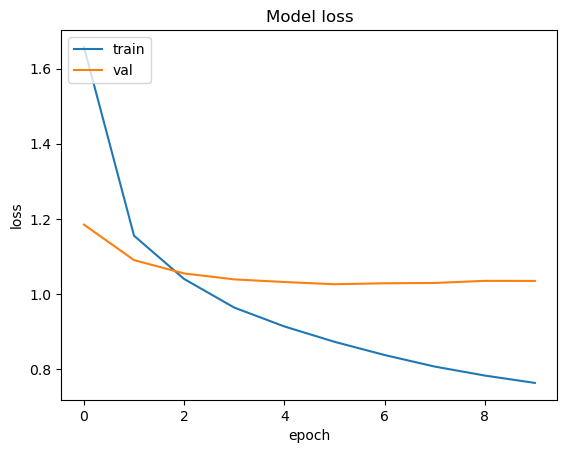

In [67]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(step1_history, 'loss')

### Step 2: Fine-Tune the whole model

In [ ]:
%%time

# Unfreeze the pretrained base. 
base_model.trainable = True

# Compile the model again
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Retrain the model
step2_history = model.fit(train_ds, epochs=10, validation_data=validation_ds) # You should us a small learning rate: for example 1e-5 or 1e-6

Epoch 1/10
268/268 [==============================] - 565s 2s/step - loss: 0.6718 - accuracy: 0.7938 - val_loss: 0.9902 - val_accuracy: 0.6993
Epoch 2/10
268/268 [==============================] - 549s 2s/step - loss: 0.6436 - accuracy: 0.7997 - val_loss: 0.9805 - val_accuracy: 0.7064
Epoch 3/10
268/268 [==============================] - 553s 2s/step - loss: 0.6254 - accuracy: 0.8065 - val_loss: 0.9729 - val_accuracy: 0.7053
Epoch 4/10
268/268 [==============================] - 557s 2s/step - loss: 0.6229 - accuracy: 0.8060 - val_loss: 0.9634 - val_accuracy: 0.7072
Epoch 5/10
268/268 [==============================] - 554s 2s/step - loss: 0.6024 - accuracy: 0.8115 - val_loss: 0.9599 - val_accuracy: 0.7120
Epoch 6/10
268/268 [==============================] - 554s 2s/step - loss: 0.5912 - accuracy: 0.8176 - val_loss: 0.9545 - val_accuracy: 0.7124
Epoch 7/10
268/268 [==============================] - 549s 2s/step - loss: 0.5766 - accuracy: 0.8207 - val_loss: 0.9516 - val_accuracy: 0.7136

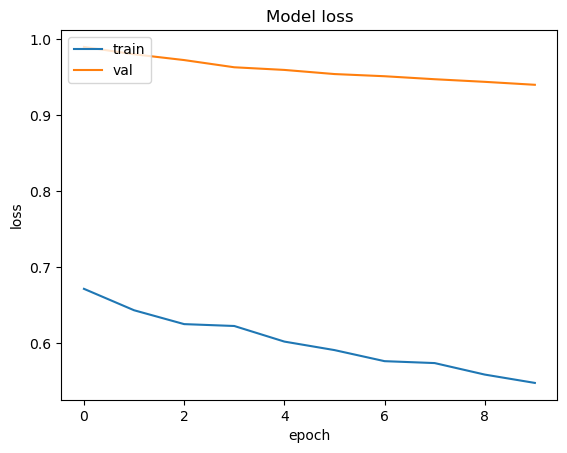

In [69]:
plot_history(step2_history, 'loss')

## Test the fine-tuned model

In [43]:
%%time
# Predict the test set
y_pred = model.predict(test_ds)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

39/39 [==============================] - 16s 393ms/step
CPU times: user 1min 16s, sys: 17.9 s, total: 1min 34s
Wall time: 16.6 s


In [44]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.7107803700724055
CPU times: user 1.16 ms, sys: 2.5 ms, total: 3.66 ms
Wall time: 12.2 ms


/var/folders/26/fnlzfq0s7lqcqtlwb5nj7_lc0000gn/T/ipykernel_47314/3096507637.py:3: RuntimeWarning: invalid value encountered in cast
  test_examples = test_examples.astype("uint32")


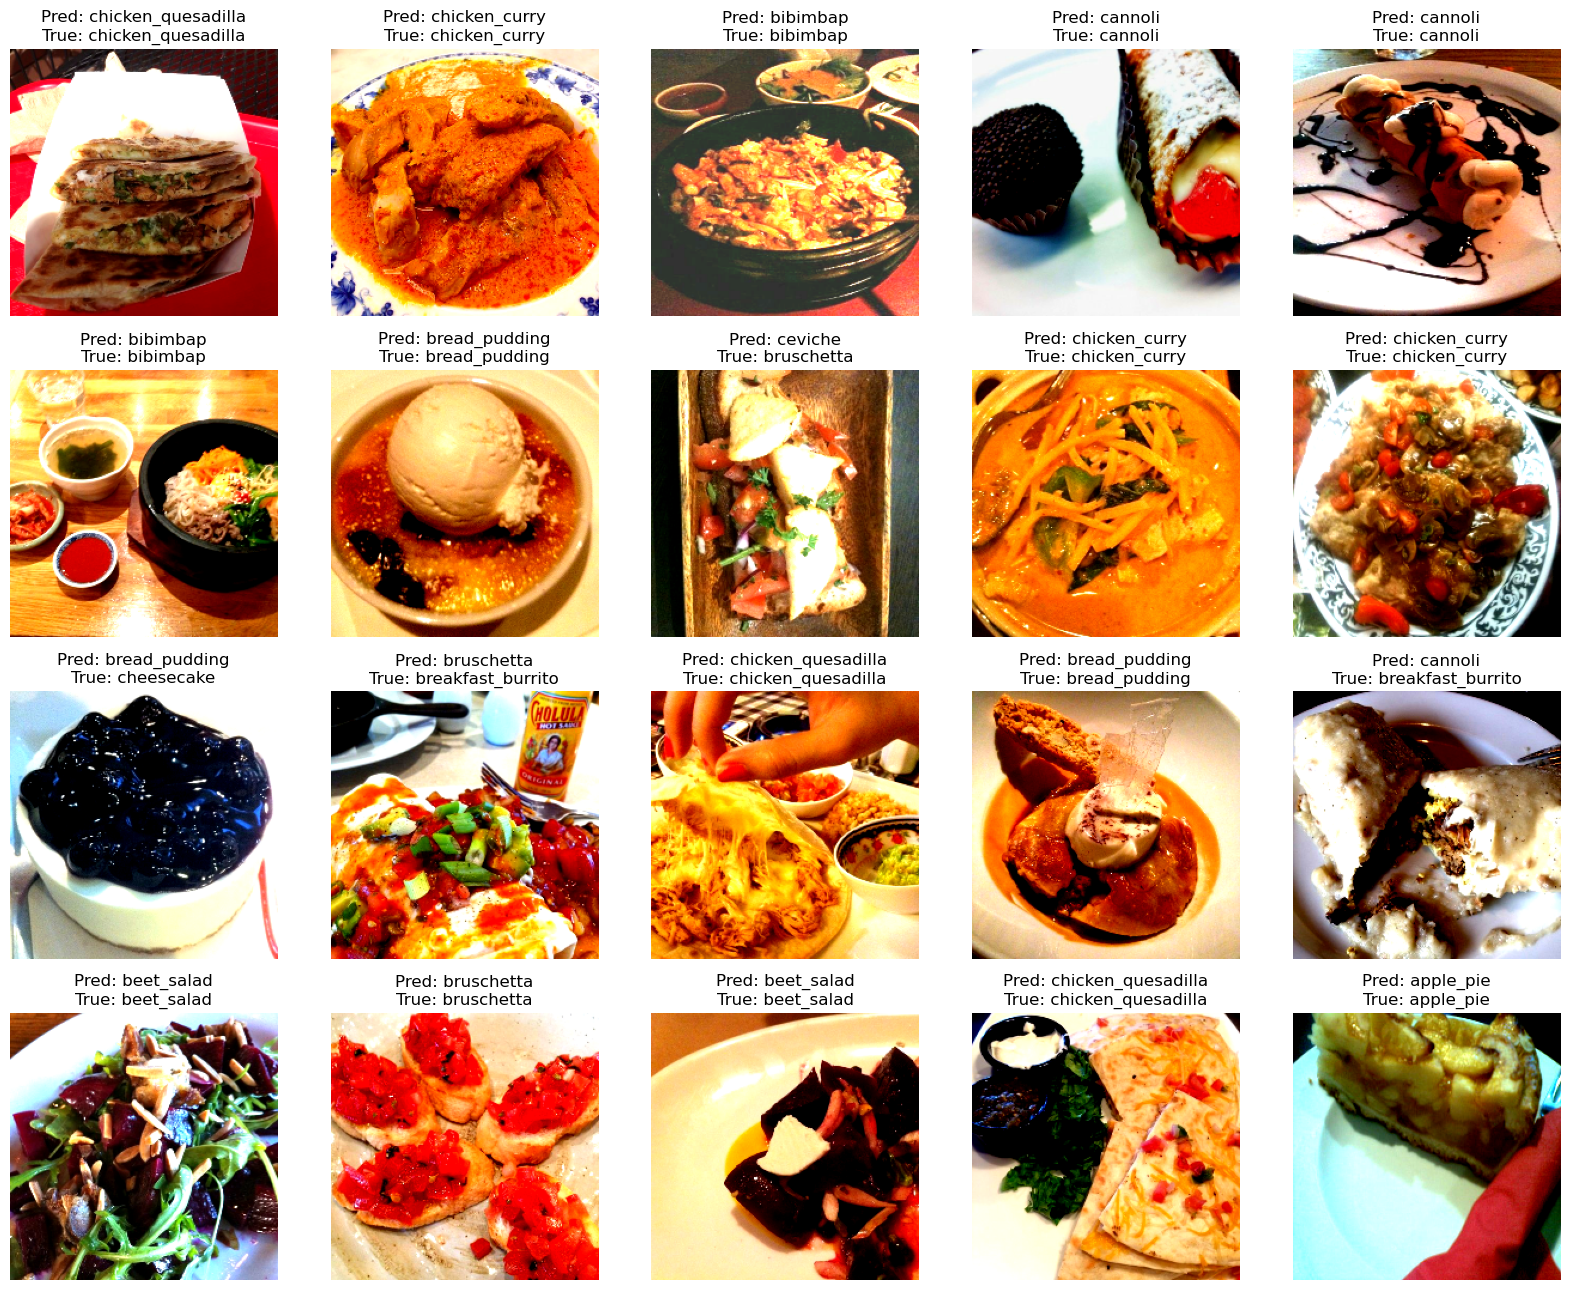

In [45]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds])+1)/2*255
    test_examples = test_examples.astype("uint32")
    
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)